In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from statsmodels.regression.linear_model import OLS

from tqdm import trange
import seaborn as sns
from scipy import stats
import statsmodels.api as sm



### 讀檔

In [2]:
df = pd.read_csv("C:/Users/user/Desktop/2330_all.csv")

# 定義code

In [3]:
import math

""" 
Stores common attributes of a stock option 
"""
class StockOption(object):
    def __init__(
        self, S0, K, r=0.05, T=1, N=2, pu=0, pd=0, 
        div=0, sigma=0, is_put=False, is_am=False):
        """
        Initialize the stock option base class.
        Defaults to European call unless specified.

        :param S0: initial stock price
        :param K: strike price
        :param r: risk-free interest rate
        :param T: time to maturity
        :param N: number of time steps
        :param pu: probability at up state
        :param pd: probability at down state
        :param div: Dividend yield
        :param is_put: True for a put option,
                False for a call option
        :param is_am: True for an American option,
                False for a European option
        """
        self.S0 = S0
        self.K = K
        self.r = r
        self.T = T
        self.N = max(1, N)
        self.STs = [] # Declare the stock prices tree

        """ Optional parameters used by derived classes """
        self.pu, self.pd = pu, pd
        self.div = div
        self.sigma = sigma
        self.is_call = not is_put
        self.is_european = not is_am

    @property
    def dt(self):
        """ Single time step, in years """
        return self.T/float(self.N)

    @property
    def df(self):
        """ The discount factor """
        return math.exp(-(self.r-self.div)*self.dt)

In [4]:
import math
import numpy as np

""" 
Price a European or American option by the binomial tree 
"""
class BinomialTreeOption(StockOption):

    def setup_parameters(self):
        self.u = 1+self.pu  # Expected value in the up state
        self.d = 1-self.pd  # Expected value in the down state
        self.qu = (math.exp(
            (self.r-self.div)*self.dt)-self.d)/(self.u-self.d)
        self.qd = 1-self.qu

    def init_stock_price_tree(self):
        # Initialize a 2D tree at T=0
        self.STs = [np.array([self.S0])]

        # Simulate the possible stock prices path
        for i in range(self.N):
            prev_branches = self.STs[-1]
            st = np.concatenate(
                (prev_branches*self.u, 
                 [prev_branches[-1]*self.d]))
            self.STs.append(st) # Add nodes at each time step

    def init_payoffs_tree(self):
        if self.is_call:
            return np.maximum(0, self.STs[self.N]-self.K)
        else:
            return np.maximum(0, self.K-self.STs[self.N])

    def check_early_exercise(self, payoffs, node):
        if self.is_call:
            return np.maximum(payoffs, self.STs[node] - self.K)
        else:
            return np.maximum(payoffs, self.K - self.STs[node])

    def traverse_tree(self, payoffs):
        for i in reversed(range(self.N)):
            # The payoffs from NOT exercising the option
            payoffs = (payoffs[:-1]*self.qu + 
                       payoffs[1:]*self.qd)*self.df

            # Payoffs from exercising, for American options
            if not self.is_european:
                payoffs = self.check_early_exercise(payoffs,i)

        return payoffs

    def begin_tree_traversal(self):
        payoffs = self.init_payoffs_tree()
        return self.traverse_tree(payoffs)

    def price(self):
        """  The pricing implementation """
        self.setup_parameters()
        self.init_stock_price_tree()
        payoffs = self.begin_tree_traversal()
        return payoffs[0]

In [5]:
import math
import numpy as np

class TrinomialTreeOption(BinomialTreeOption):

    def setup_parameters(self):
        """ Required calculations for the model """
        self.u = 1
        self.d = 1
        self.m = 0
        self.qu = 0.05
        self.qd = 0.05

        self.qm = 1 - self.qu - self.qd

    def init_stock_price_tree(self):
        # Initialize a 2D tree at t=0
        self.STs = [np.array([self.S0])]

        for i in range(self.N):
            prev_nodes = self.STs[-1]
            self.ST = np.concatenate(
                (prev_nodes+self.u, [prev_nodes[-1]+self.m,
                                     prev_nodes[-1]-self.d]))
            self.STs.append(self.ST)

    def traverse_tree(self, payoffs):
        # Traverse the tree backwards 
        for i in reversed(range(self.N)):
            payoffs = (payoffs[:-2] * self.qu +
                       payoffs[1:-1] * self.qm +
                       payoffs[2:] * self.qd) * self.df

            if not self.is_european:
                payoffs = self.check_early_exercise(payoffs,i)

        return payoffs

In [6]:
import numpy as np

""" 
Price an option by the trinomial lattice 
"""
class TrinomialLattice(TrinomialTreeOption):

    def setup_parameters(self):
        super(TrinomialLattice, self).setup_parameters()
        self.M = 2*self.N + 1

    def init_stock_price_tree(self):
        self.STs = np.zeros(self.M)
        self.STs[0] = self.S0 * self.u**self.N

        for i in range(self.M)[1:]:
            self.STs[i] = self.STs[i-1]*self.d

    def init_payoffs_tree(self):
        if self.is_call:
            return np.maximum(0, self.STs-self.K)
        else:
            return np.maximum(0, self.K-self.STs)

    def check_early_exercise(self, payoffs, node):
        self.STs = self.STs[1:-1]  # Shorten ends of the list
        if self.is_call:
            return np.maximum(payoffs, self.STs-self.K)
        else:
            return np.maximum(payoffs, self.K-self.STs)

In [7]:
df = df[df["ask_1"]!= 0]
df = df.dropna()

In [8]:
df = df.reset_index()

In [9]:
spread_1 = TrinomialTreeOption(581, 580.5, 
    r=0.0001, T=1, N=240, sigma=0.006, is_put=True, is_am=True)
spread_2 = TrinomialTreeOption(582, 580.5, 
    r=0.0001, T=1, N=240, sigma=0.006, is_put=True, is_am=True)
spread_3 = TrinomialTreeOption(583, 580.5, 
    r=0.0001, T=1, N=240, sigma=0.006, is_put=True, is_am=True)
spread_4 = TrinomialTreeOption(584, 580.5, 
    r=0.0001, T=1, N=240, sigma=0.006, is_put=True, is_am=True)
spread_5 = TrinomialTreeOption(585, 580.5, 
    r=0.0001, T=1, N=240, sigma=0.006, is_put=True, is_am=True)
spread_6 = TrinomialTreeOption(586, 580.5, 
    r=0.0001, T=1, N=240, sigma=0.006, is_put=True, is_am=True)
spread_7 = TrinomialTreeOption(587, 580.5, 
    r=0.0001, T=1, N=240, sigma=0.006, is_put=True, is_am=True)


In [10]:
spread_11 = TrinomialTreeOption(581, 580, 
    r=0.0001, T=1, N=240, sigma=0.006, is_put=True, is_am=True)
spread_12 = TrinomialTreeOption(582, 580, 
    r=0.0001, T=1, N=240, sigma=0.006, is_put=True, is_am=True)
spread_13 = TrinomialTreeOption(583, 580, 
    r=0.0001, T=1, N=240, sigma=0.006, is_put=True, is_am=True)
spread_14 = TrinomialTreeOption(584, 580, 
    r=0.0001, T=1, N=240, sigma=0.006, is_put=True, is_am=True)
spread_15 = TrinomialTreeOption(585, 580, 
    r=0.0001, T=1, N=240, sigma=0.006, is_put=True, is_am=True)


In [11]:
para_1 = spread_1.price()
para_2 = spread_2.price()
para_3 = spread_3.price()
para_4 = spread_4.price()
para_5 = spread_5.price()
para_6 = spread_6.price()
para_7 = spread_7.price()
para_11 = spread_11.price()
para_12 = spread_12.price()
para_13 = spread_13.price()
para_14 = spread_14.price()
para_15 = spread_15.price()

para_all5 = para_1+para_2+para_3+para_4+para_5
para_all6 = para_2+para_3+para_4+para_5+para_6
para_all7 = para_7+para_3+para_4+para_5+para_6

In [12]:
df["theo_option"] = df["ask_1"]
for i in trange(0,len(df["theo_option"])):
    if df["ask_1"].iloc[i] - df["bid_1"].iloc[i] == 2:
        df["theo_option"].iloc[i] = df["bid_1"].iloc[i]+(df["bid_qty1"].iloc[i]*para_11+df["bid_qty2"].iloc[i]*para_12+df["bid_qty3"].iloc[i]*para_13+df["bid_qty4"].iloc[i]*para_14+df["bid_qty5"].iloc[i]*para_15)/((df["ask_qty1"].iloc[i]*para_11+df["ask_qty2"].iloc[i]*para_12+df["ask_qty3"].iloc[i]*para_13+df["ask_qty4"].iloc[i]*para_14+df["ask_qty5"].iloc[i]*para_15+df["bid_qty1"].iloc[i]*para_11+df["bid_qty2"].iloc[i]*para_12+df["bid_qty3"].iloc[i]*para_13+df["bid_qty4"].iloc[i]*para_14+df["bid_qty5"].iloc[i]*para_15))
    elif df["ask_1"].iloc[i] - df["bid_1"].iloc[i] == 3:
        df["theo_option"].iloc[i] = df["bid_1"].iloc[i]+(df["bid_qty1"].iloc[i]*para_2+df["bid_qty2"].iloc[i]*para_3+df["bid_qty3"].iloc[i]*para_4+df["bid_qty4"].iloc[i]*para_5+df["bid_qty5"].iloc[i]*para_6)/((df["ask_qty1"].iloc[i]*para_2+df["ask_qty2"].iloc[i]*para_3+df["ask_qty3"].iloc[i]*para_4+df["ask_qty4"].iloc[i]*para_5+df["ask_qty5"].iloc[i]*para_6+df["bid_qty1"].iloc[i]*para_2+df["bid_qty2"].iloc[i]*para_3+df["bid_qty3"].iloc[i]*para_4+df["bid_qty4"].iloc[i]*para_5+df["bid_qty5"].iloc[i]*para_6))
    else:
        df["theo_option"].iloc[i] = df["bid_1"].iloc[i]+(df["bid_qty1"].iloc[i]*para_1+df["bid_qty2"].iloc[i]*para_2+df["bid_qty3"].iloc[i]*para_3+df["bid_qty4"].iloc[i]*para_4+df["bid_qty5"].iloc[i]*para_5)/((df["ask_qty1"].iloc[i]*para_1+df["ask_qty2"].iloc[i]*para_2+df["ask_qty3"].iloc[i]*para_3+df["ask_qty4"].iloc[i]*para_4+df["ask_qty5"].iloc[i]*para_5+df["bid_qty1"].iloc[i]*para_1+df["bid_qty2"].iloc[i]*para_2+df["bid_qty3"].iloc[i]*para_3+df["bid_qty4"].iloc[i]*para_4+df["bid_qty5"].iloc[i]*para_5))

  0%|                                                                                        | 0/57017 [00:00<?, ?it/s]C:\Users\user\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
100%|██████████████████████████████████████████████████████████████████████████| 57017/57017 [00:23<00:00, 2404.83it/s]


In [13]:
df["theo_option"]

0        581.531228
1        581.532256
2        581.532558
3        581.536846
4        581.544127
            ...    
57012    590.474049
57013    590.463442
57014    590.471471
57015    590.474663
57016    590.469186
Name: theo_option, Length: 57017, dtype: float64

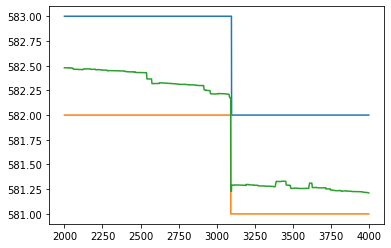

In [14]:
plt.plot(df["ask_1"][2000:4000])
plt.plot(df["bid_1"][2000:4000])
plt.plot(df["theo_option"][2000:4000])
# plt.plot(df["theo"][0:10000])

In [15]:
df["theo_option_pct"] = df["theo_option"].pct_change(1)
df = df.dropna()

In [167]:
print(range(29))

range(0, 29)


In [16]:
df.index[0:1000]

Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
             991,  992,  993,  994,  995,  996,  997,  998,  999, 1000],
           dtype='int64', length=1000)

In [20]:
df["spread"] = df["ask_1"] - df["bid_1"]
df["total_qty"] = df["ask_qty1"] + df["bid_qty1"]
df["flow_imbalance"] = df["bid_qty1"] - df["ask_qty1"]
df["weighted_qty"] = df["total_qty"]*(np.log(df["spread"]+1))
df["mid_1"] = df["bid_1"]+ (df["ask_1"] - df["bid_1"])/2
df["mid_pct"] = df["mid_1"].pct_change(1)

In [66]:
df["coef"] = df["theo_option_pct"]*0
for i in trange(200,len(df["theo_option_pct"])):
    res = OLS(df.index[0:200],df["theo_option_pct"].iloc[i-200:i])
    results = res.fit()
    df["coef"].iloc[i] = results.params[0]/1000000

100%|███████████████████████████████████████████████████████████████████████████| 56816/56816 [01:08<00:00, 826.05it/s]


C:\Users\user\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


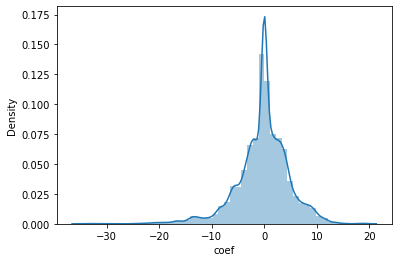

In [289]:
sns.distplot(np.sign(df["coef"])*np.abs((df["coef"]))**(1/1.4))
stats.kurtosis(np.sign(df["coef"])*np.abs((df["coef"]))**(1/1.4))
df["coef"] = np.sign(df["coef"])*np.abs((df["coef"]))**(1/1.4)

In [317]:
df["action"] = df["coef"]*0
for i in trange(0, len(df["coef"])):
    if df["coef"].iloc[i]>10  and df["coef"].iloc[i]<20 and df["action"].iloc[0:i].sum() == 0:
        df["action"].iloc[i] = 1
    elif df["coef"].iloc[i]>12 and df["action"].iloc[0:i].sum() == -1:
        df["action"].iloc[i] = 1
    elif df["coef"].iloc[i]>13 and df["action"].iloc[0:i].sum() == -1:
        df["action"].iloc[i] = 2
    elif df["coef"].iloc[i]<-13 and df["action"].iloc[0:i].sum() == 0:
        df["action"].iloc[i] = -1
    elif df["coef"].iloc[i]<-15 and df["action"].iloc[0:i].sum() == 1:
        df["action"].iloc[i] = -2        
    elif df["coef"].iloc[i]<-10 and df["action"].iloc[0:i].sum() == 1:
        df["action"].iloc[i] = -1


100%|█████████████████████████████████████████████████████████████████████████| 57016/57016 [00:04<00:00, 13116.67it/s]


In [318]:
len(df[df["action"]<0])

17

100%|████████████████████████████████████████████████████████████████████████| 57016/57016 [00:00<00:00, 106252.85it/s]


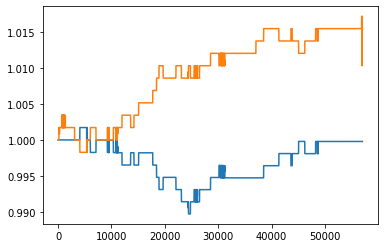

In [319]:
df["position"] = df["action"].cumsum()
df["return"] = df["position"]*df["mid_pct"]
df["fee"] = df["return"]*0
for i in trange(0,len(df["action"])):
    if df["action"].iloc[i]<0:
        df["fee"].iloc[i] = (np.abs(df["action"].iloc[i]/df["action"].iloc[i] ))*0.0015

# for i in range(0,len(df["return"])):
#     if df["action"].iloc[i] == -1:
#         df["return"].iloc[i] = df["return"].iloc[i]-0.0015
df["return2"] = (df["return"]+1).cumprod()
plt.plot(df["return2"])
plt.plot((df["mid_pct"]+1).cumprod())

In [239]:
df["theo_option"][df["coef"]<-3].index

Int64Index([ 1995,  1996,  1997,  1998,  1999,  2000,  2001,  2002,  2003,
             2004,
            ...
            55225, 55226, 55227, 55228, 55229, 55230, 55231, 55232, 55794,
            55796],
           dtype='int64', length=15264)

In [33]:
start = 0
end = 57000

In [314]:
high_index=df["theo_option"].iloc[start:end][df["coef"]>10][df["coef"]<15].index
low_index=df["theo_option"].iloc[start:end][df["coef"]>-15][df["coef"]<-10].index

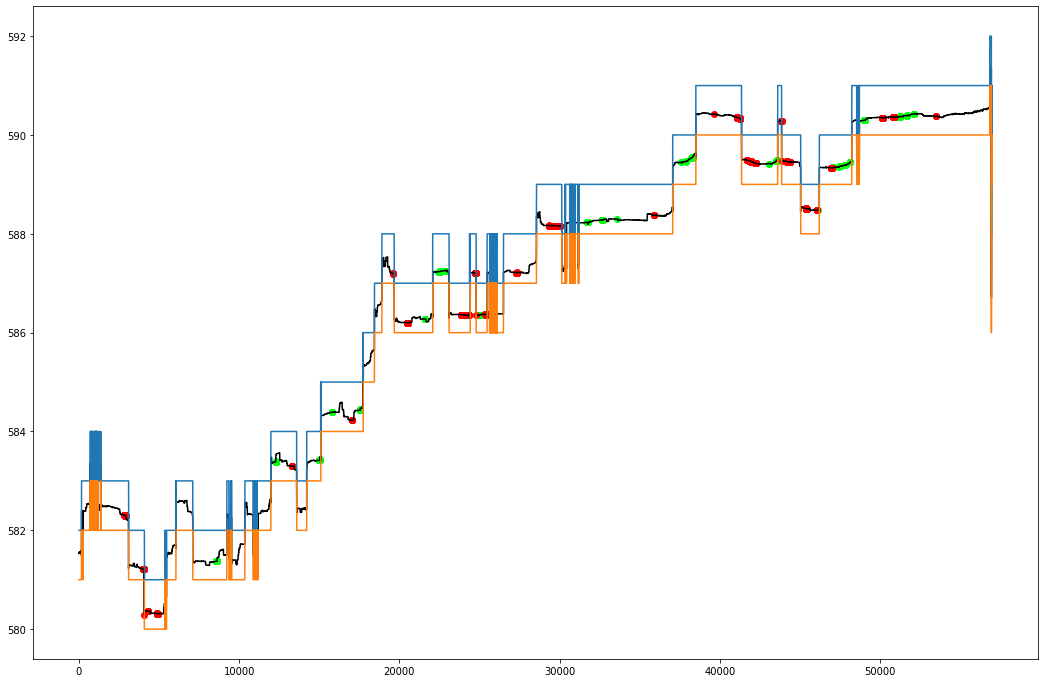

In [315]:
plt.figure(figsize = (18,12))
plt.plot(df["theo_option"].iloc[start:end],c = "black")
plt.scatter(high_index,df["theo_option"].loc[high_index],c='#02ff0f',label='coef')
plt.scatter(low_index,df["theo_option"].loc[low_index],c="red",label='coef2')

plt.plot(df["ask_1"].iloc[start:end])
plt.plot(df["bid_1"].iloc[start:end])

In [276]:
crit = 1

In [149]:
for i in range(0,100):
    crit = i/100
    print(df["coef"][df["coef"]>-crit][df["coef"]<crit].corr(df["mid_pct5"][df["coef"]>-crit][df["coef"]<crit]),"|",i)

KeyError: 'mid_pct5'

In [ ]:
df["buy_point"] = df["action"]